# Quick Start on `MLflow`

This is a notebook for a walk-through on how you can leverage MLflow in Databricks in your daily workflow. The example in this notebook demonstrate the following:
1. `MLflow`'s basic concepts, especially its components
2. Train a linear regression model
3. Package the code that trains the model in a reusable and reproducible model format
4. Deploy the model that will enable the users to score predictions

## MLflow Components

MLflow provides four components to help manage the ML workflow:

**MLflow Tracking** is an API and UI for logging parameters, code versions, metrics, and artifacts when running your machine learning code and for later visualizing the results. You can use MLflow Tracking in any environment (for example, a standalone script or a notebook) to log results to local files or to a server, then compare multiple runs. Teams can also use it to compare results from different users.

**MLflow Projects** are a standard format for packaging reusable data science code. Each project is simply a directory with code or a Git repository, and uses a descriptor file or simply convention to specify its dependencies and how to run the code. For example, projects can contain a conda.yaml file for specifying a Python Conda environment. When you use the MLflow Tracking API in a Project, MLflow automatically remembers the project version (for example, Git commit) and any parameters. You can easily run existing MLflow Projects from GitHub or your own Git repository, and chain them into multi-step workflows.

**MLflow Models** offer a convention for packaging machine learning models in multiple flavors, and a variety of tools to help you deploy them. Each Model is saved as a directory containing arbitrary files and a descriptor file that lists several “flavors” the model can be used in. For example, a TensorFlow model can be loaded as a TensorFlow DAG, or as a Python function to apply to input data. MLflow provides tools to deploy many common model types to diverse platforms: for example, any model supporting the “Python function” flavor can be deployed to a Docker-based REST server, to cloud platforms such as Azure ML and AWS SageMaker, and as a user-defined function in Apache Spark for batch and streaming inference. If you output MLflow Models using the Tracking API, MLflow also automatically remembers which Project and run they came from.

**MLflow Registry** offers a centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of an MLflow Model. It provides model lineage (which MLflow experiment and run produced the model), model versioning, stage transitions (for example from staging to production or archiving), and annotations.

## Model Training
The following example demonstrates how to train a Elastic Net regression model (Linear regression with combined L1 and L2 priors as regularizer) and visualize the path of the regulizers and the coefficients. The problem is solved in the following steps:
1. Define a function to draw the path of the regulizers and the coefficients from the Elastic Net regression model.
2. Split the data into train and test set. Then training the ElasticNet model with train set.
3. Predict the targets using the test set with the trained ElasticNet regression.
4. Log the trained model and save the trained model.
5. Deploy the model for further predictions.

##Highlights
One of the key functions of `mlflow` is to track the changes in the experiments. These functions can be realized through the `log` and `save` functions built in `mlflow`. The outputs of the experiment such as parameters, metrics and models, can all be logged as artifacts at the end. Artifacts refers to output files in any format. For example, you can record images (for example, PNGs), models (for example, a pickled scikit-learn model), and data files (for example, a Parquet file) as artifacts. The logic of logging and saving these output files are similar so the model logging and saving process is used as an example to illustrate how the `log` and `save` functions work in `mlflow`.

`save_model()` and `log_model()` support the following workflows:

1. Programmatically defining a new MLflow model, including its attributes and artifacts.

    Given a set of artifact URIs, `save_model()` and `log_model()` can automatically download artifacts from their URIs and create an MLflow model directory.

    In this case, you must define a Python class which inherits from PythonModel, defining `predict()` and, optionally, `load_context()`. An instance of this class is specified via the `python_model` parameter; it is automatically serialized and deserialized as a Python class, including all of its attributes.

2. Interpreting pre-existing data as an MLflow model.

    If you already have a directory containing model data, `save_model()` and `log_model()` can import the data as an MLflow model. The data_path parameter specifies the local filesystem path to the directory containing model data.

    In this case, you must provide a Python module, called a loader module. The loader module defines a `_load_pyfunc()` method that performs the following tasks:

     - Load data from the specified data_path. For example, this process may include deserializing pickled Python objects or models or parsing CSV files.

     - Construct and return a pyfunc-compatible model wrapper. As in the first use case, this wrapper must define a `predict()` method that is used to evaluate queries. `predict()` must adhere to the Inference API.

   The loader_module parameter specifies the name of your loader module.

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
 %reload_ext autoreload

In [ ]:
%pip install mlflow

In [8]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import ElasticNet, lasso_path, enet_path
from sklearn import datasets
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import mlflow.pyfunc as pf

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [9]:
#check the version of mlflow
mlflow.__version__

Out[2]: '1.9.1'

In [10]:
#load the data
df = datasets.load_diabetes()
X = df.data
y = df.target

Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
df = pd.DataFrame(d, columns=cols)

## How to Build MLflow

First, define a function to draw the ElasticNet path of the regulizer and the coefficients. The graph of this ElasticNet path is one of the artifacts we want to log and save.

In [13]:
def plot_enet_descent_path(X, y, l1_ratio):
    eps = 5e-3
  
    global image
    print("Computing regularization path using ElasticNet")
  
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

    fig = plt.figure(1)
    ax = plt.gca

    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas = -np.log10(alphas_enet)
    for coef, c in zip(coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas, coef, ls='--', c=c)
    plt.xlabel('-log(alpha)')
    plt.ylabel('coefficients')
    plt.title(f'ElasticNet Path by alpha for l1 ratio {l1_ratio}')
    plt.axis('tight')

    image = fig
    fig.savefig('ElasticNet_path.png')

    plt.close(fig)
  
  return image

Next, define a training function `train_model` to wrap the `mlflow` trainer. Inside the `mlflow`, the training regression model is specified. So the pseudo code works as follows:

```
carte a mlflow container:
  define your training model
  train the model
  log the parameters if necessary
  log the metrics if necessary
  log the model
  save the model
  log the artifacts if necessaery
```

As shown below, the pseudo code for `sklearn` models works as follows:
```
carte a mlflow container with mlflow.start_run():
  select your training model
  fit the model with train set
  predict the model with test set
  log the parameters if necessary
  log the metrics if necessary
  log the model
  save the model
  log the artifacts if necessary
```

In [15]:
def train_model(df, alpha, l1_ratio):
    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

    warnings.filterwarnings('ignore')
    np.random.seed(24)
 
    train, test = train_test_split(df)

    X_train = train.drop('progression', axis=1)
    X_test = test.drop('progression', axis=1)
    y_train = train['progression']
    y_test = test['progression']
    print(sys.argv)
    alpha = float(alpha) if float(alpha) != None else 0.5
    l1_ratio = float(l1_ratio) if float(l1_ratio) != None else 0.5

    with mlflow.start_run():
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=24)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        (rmse, mae, r2) = eval_metrics(y_pred, y_test)

    print(f'ElasticNet model (alpha=%f, l1_ratio=%f): {(alpha, l1_ratio)}')
    print("  RMSE: %s" % rmse)
    print(f"  MAE: {mae}")
    print("  R2: %s" % r2)

    mlflow.log_param('alpha', alpha)
    mlflow.log_param('l1_ratio', l1_ratio)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)
    mlflow.log_metric('mae', mae)

    mlflow.sklearn.log_model(lr,'model', 
                             conda_env={'name': 'mlflow-env',
                                       'channels': ['defaults'],
                                       'dependencies': ['python=3.7.3',
                                        'scikit-learn=0.20.3',
                                        'pip',
                                        {'pip': ['mlflow']}]}, 
                             serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
    model_path = '/Users/junxiao.ma@cloud.statcan.ca/mlflow_model_%f_%f' % (alpha, l1_ratio)
    mlflow.sklearn.save_model(sk_model=lr, path=model_path,
                             conda_env={'name': 'mlflow-env',
                                       'channels': ['defaults'],
                                       'dependencies': ['python=3.7.3',
                                        'scikit-learn=0.20.3',
                                        'pip',
                                        {'pip': ['mlflow']}]}, 
                             serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
    
    image = plot_enet_descent_path(X, y, l1_ratio)
    
    mlflow.log_artifact('ElasticNet_path.png')

Now the work flow of training the ElasticNet regression has been constructed using `mlflow`. Then we can run this work flow with different parameters meanwhile log and save the model as a new experiment.

In [17]:
train_model(df, 0.01, 0.0511)

['/local_disk0/tmp/1598549970897-0/PythonShell.py', '42781', '0', '50000', '975', '93053ef912e34fd48aff6b12555e9cab', '3.0.0', 'eb5f72ba7e315da9f183fcb3b5cca44545705bfafad61338289608e85b810965', 'unpinned']
ElasticNet model (alpha=%f, l1_ratio=%f): (0.01, 0.0511)
 RMSE: 64.08258899423615
 MAE: 55.51393536847639
 R2: -8.271617650394909
Computing regularization path using ElasticNet

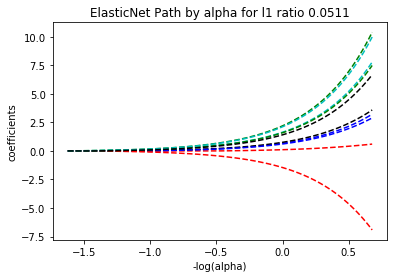

In [18]:
display(image)

Once a new experiment is conducted, then one can click the experiment button at the up-right corner of the notebook. Then a list of historical experiments will be shown in a databricks window. Each experiment represents one version of the model with specific logged parameters and metrics.

<img src="https://docs.databricks.com/_static/images/mlflow/mlflow-notebook-experiments-python.gif"/>

<img src="image/mlflow_test_1.png"/>

<img src="image/mlflow_test_2.png"/>

If one clicks one of the experiments listed, then the logged parameters, evluation metrics and model-related information can be shown in more details. More importantly the artifacts stored ina dictionary can be extracted with specific model informations such as the conda.yaml file that records all the depedency information of that model.

<img src="image/mlflow_test_3.png"/>

<img src="image/mlflow_test_4.png"/>

In [21]:
train_model(df, 0.01, 0.73)

['/local_disk0/tmp/1598383899419-0/PythonShell.py', '38453', '0', '50000', '2265', 'ef35276c7328480790f8248208d2f054', '2.4.5', '231bb4ee2e6e7dcfab13dbc8ba28d734fbc87529e29f6d721b43d9ae44e052cb', 'unpinned']
ElasticNet model (alpha=%f, l1_ratio=%f): (0.01, 0.73)
 RMSE: 58.05252269483471
 MAE: 49.512071227732925
 R2: -1.8453502642948658
Computing regularization path using ElasticNet

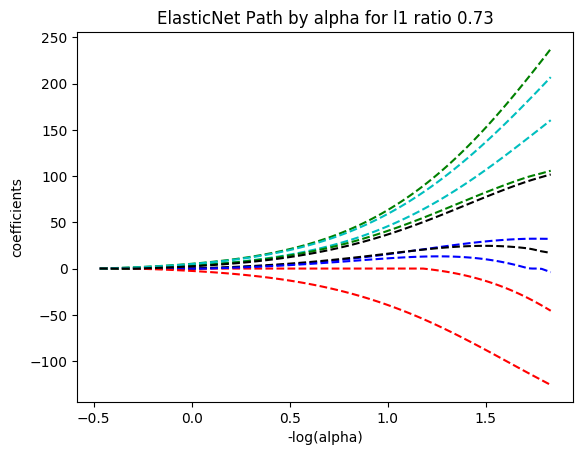

In [22]:
display(image)

In [23]:
train_model(df, 0.01, 0.61)

['/local_disk0/tmp/1598383899419-0/PythonShell.py', '38453', '0', '50000', '2265', 'ef35276c7328480790f8248208d2f054', '2.4.5', '231bb4ee2e6e7dcfab13dbc8ba28d734fbc87529e29f6d721b43d9ae44e052cb', 'unpinned']
ElasticNet model (alpha=%f, l1_ratio=%f): (0.01, 0.61)
 RMSE: 59.499594408979036
 MAE: 51.10352066022366
 R2: -2.737029798795468
Computing regularization path using ElasticNet

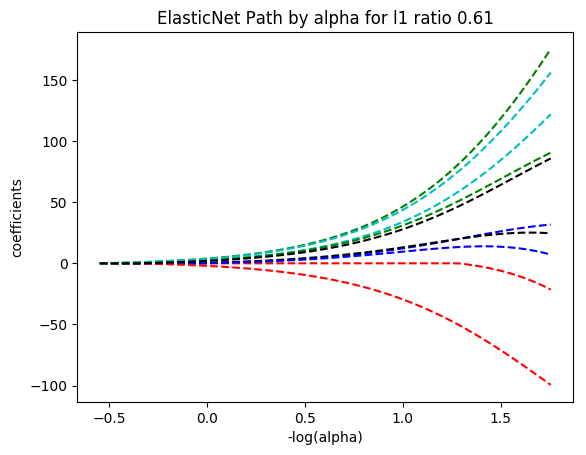

In [24]:
display(image)

## Prediction

Now we have a training workflow, we can use this workflow to do further prediction. The first step is to select the specific version of the model required for prediction. Therefore, we need a artifact path, which is called URI, to specify which model to use and where it is located. A URI is an artifact path either in a local or distributed storage system. MLflow converts relative paths to absolute paths, as in the path type. Use this type for programs that know how to read from distributed storage (e.g., programs that use Spark).

In [27]:
#specify the URI for loading the model
run_id1 = "bee26ecd10ec491ebe805284d4d5d85c"
model_uri = "runs:/" + run_id1 + "/model"

In [28]:
dataframe = spark.createDataFrame(df.drop(["progression"], axis=1))

Using the user-defined functions (udf) built in spark we can transform the prediction task into a function. All we need to do is to fill in the the model URI information into that user-defined function. Since we already include the `model.predict()` in the training flow, this udf will automatically call that trained model and make predictions based on the data fed in.

In [30]:
pyfunc_udf = pf.spark_udf(spark, model_uri=model_uri)

In [31]:
predicted_df = dataframe.withColumn("prediction", pyfunc_udf('age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'))
display(predicted_df)

age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,prediction
0.0380759064334241,0.0506801187398187,0.0616962065186885,0.0218723549949558,-0.0442234984244464,-0.0348207628376986,-0.0434008456520269,-0.00259226199818282,0.0199084208763183,-0.0176461251598052,167.59340384748003
-0.00188201652779104,-0.044641636506989,-0.0514740612388061,-0.0263278347173518,-0.00844872411121698,-0.019163339748222,0.0744115640787594,-0.0394933828740919,-0.0683297436244215,-0.09220404962683,118.13221293724386
0.0852989062966783,0.0506801187398187,0.0444512133365941,-0.00567061055493425,-0.0455994512826475,-0.0341944659141195,-0.0323559322397657,-0.00259226199818282,0.00286377051894013,-0.0259303389894746,159.6818672779814
-0.0890629393522603,-0.044641636506989,-0.0115950145052127,-0.0366564467985606,0.0121905687618,0.0249905933641021,-0.0360375700438527,0.0343088588777263,0.0226920225667445,-0.0093619113301358,155.05967835669284
0.00538306037424807,-0.044641636506989,-0.0363846922044735,0.0218723549949558,0.00393485161259318,0.0155961395104161,0.0081420836051921,-0.00259226199818282,-0.0319914449413559,-0.0466408735636482,142.5001413008503
-0.0926954778032799,-0.044641636506989,-0.0406959404999971,-0.0194420933298793,-0.0689906498720667,-0.0792878444118122,0.0412768238419757,-0.076394503750001,-0.0411803851880079,-0.0963461565416647,118.9737289118545
-0.0454724779400257,0.0506801187398187,-0.0471628129432825,-0.015999222636143,-0.040095639849843,-0.0248000120604336,7.78807997017968E-4,-0.0394933828740919,-0.0629129499162512,-0.0383566597339788,126.85535542134352
0.063503675590561,0.0506801187398187,-0.00189470584028465,0.0666296740135272,0.0906198816792644,0.108914381123697,0.0228686348215404,0.0177033544835672,-0.0358167281015492,0.00306440941436832,158.87320519809694
0.0417084448844436,0.0506801187398187,0.0616962065186885,-0.0400993174922969,-0.0139525355440215,0.00620168565673016,-0.0286742944356786,-0.00259226199818282,-0.0149564750249113,0.0113486232440377,159.8409938383167
-0.0709002470971626,-0.044641636506989,0.0390621529671896,-0.0332135761048244,-0.0125765826858204,-0.034507614375909,-0.0249926566315915,-0.00259226199818282,0.0677363261102861,-0.0135040182449705,164.15729728569306


In [32]:
# model = mlflow.sklearn.load_model(model_uri=model_id)
# model.coef_

Out[246]: array([ 25.00011705, -21.79978432, 151.5305382 , 95.4779536 ,
 27.31118268, 10.99091487, -79.12535184, 71.76395321,
 128.21049009, 85.7834501 ])

In [33]:
# model.predict(df.drop(["progression"], axis=1))

Out[248]: array([167.51521575, 118.31357745, 159.65232778, 155.05185537,
 142.56329328, 119.11872231, 126.99891314, 158.89576809,
 159.81869182, 164.07811601, 120.97460365, 145.76445911,
 135.46931877, 156.56764301, 131.15031998, 171.54997568,
 166.28163415, 171.9092902 , 145.47124913, 135.38723203,
 135.69259528, 130.88774688, 137.24752351, 204.15770605,
 147.41782063, 151.21949317, 120.59950449, 155.10010221,
 136.86858514, 159.49989937, 148.61061733, 115.96200128,
 191.69206688, 128.30655025, 120.84394403, 135.58148931,
 162.2293031 , 145.83607479, 193.74360062, 151.20974842,
 169.81744196, 117.2645978 , 147.83181391, 131.09191723,
 178.07109246, 144.89670278, 134.59919267, 122.5226789 ,
 133.42069155, 166.99288575, 149.34884492, 157.61482904,
 147.02542514, 157.63158245, 146.967769 , 124.54479259,
 161.85382803, 113.21923546, 124.63685035, 157.56161903,
 126.47186682, 163.26534997, 126.01339601, 134.0439782 ,
 139.915262 , 169.76622476, 158.45155056, 149.232746 ,
 143.08103769, 138.00627348, 129.54377228, 181.76148219,
 160.25634132, 152.62149656, 160.1016888 , 149.36487442,
 156.24667824, 124.45692352, 143.50270826, 131.91046504,
 163.19235683, 150.39765128, 120.71257396, 140.6538042 ,
 110.75915213, 150.82302119, 121.53215855, 149.44420084,
 132.92280255, 134.38957831, 125.85133359, 170.5441419 ,
 158.67173409, 116.1464367 , 127.00721405, 137.56653133,
 176.25041904, 177.96441349, 139.89128821, 147.32676536,
 159.62172365, 143.65581395, 148.21516245, 164.50965568,
 144.67005847, 144.42573077, 116.4555229 , 159.00082607,
 177.37680444, 166.34912188, 124.56363054, 138.75931643,
 150.63723114, 181.64911223, 196.05920704, 176.11217818,
 179.16481197, 193.30660784, 166.04713371, 146.9379926 ,
 148.08737597, 170.13306561, 187.68137023, 190.56099485,
 149.55057215, 162.82127125, 112.88614697, 136.30800727,
 125.72932085, 177.98055385, 184.80664069, 117.50072526,
 150.33685596, 121.91041257, 141.0541367 , 177.49396693,
 112.21447801, 172.27745851, 187.6540249 , 176.66104199,
 159.163538 , 190.87857986, 166.2415766 , 136.66866374,
 170.97416397, 167.52653462, 169.88926776, 176.88991719,
 147.19894442, 160.29032101, 166.17499673, 143.62411593,
 182.62133258, 150.37395829, 158.97063083, 180.63606148,
 141.75923086, 153.18136213, 129.23217342, 174.5582427 ,
 125.16068878, 200.72465281, 145.92602813, 173.53818353,
 145.78489847, 122.35257679, 114.50077201, 195.76124454,
 195.78813823, 184.2184609 , 124.47379441, 122.84607418,
 186.92492663, 126.50506661, 149.62421153, 139.97936223,
 161.54834022, 180.93306012, 135.40830118, 158.21619615,
 163.51506234, 134.26108617, 171.98203466, 161.61455259,
 165.29223705, 162.56022359, 172.64595225, 109.60903304,
 156.97259603, 138.49650834, 163.74580953, 139.01668808,
 136.29631696, 163.5882118 , 145.29233301, 168.22688513,
 138.60655968, 172.37353792, 140.70391233, 161.18467779,
 142.55311131, 131.02568159, 171.72786265, 177.65251443,
 171.23025662, 166.91802446, 162.27763276, 168.643966 ,
 184.35821325, 161.26152684, 142.58318589, 155.98676269,
 154.98534708, 134.36995798, 122.37824489, 192.4738812 ,
 191.06647263, 179.18882169, 145.35095868, 135.5580012 ,
 122.20850899, 143.83868572, 150.70654741, 129.63150996,
 122.9029017 , 177.56091195, 124.34673411, 141.05267874,
 136.59559207, 138.43606466, 180.23379545, 154.08506722,
 166.41128077, 142.63996437, 177.45111822, 164.78412888,
 169.98483888, 126.36449988, 167.20769629, 167.02966933,
 182.9270468 , 152.95695007, 123.393895 , 137.21357008,
 144.65252364, 120.71479873, 143.07861487, 118.38915105,
 192.67691372, 183.53060667, 186.11560498, 203.18340493,
 163.52131589, 178.74556032, 201.37142983, 137.77425779,
 182.90975014, 133.26878336, 158.77366426, 150.60448254,
 119.3980155 , 140.21561649, 190.17008017, 118.77078404,
 147.38951475, 149.65287939, 116.11958291, 158.21492697,
 194.29751309, 125.51828593, 162.01747614, 158.63900619,
 136.43035293, 182.70336353, 158.61520558, 159.72091843,
 169.55084644, 130.28616533, 150.18288325, 140.7639559 ,
